<h2 style='text-align: center;'>ID5004: AI in Predictive Maintenance, Reliability, and
Warranty
Assignment: Multivariate Statistics and Fault Detection</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

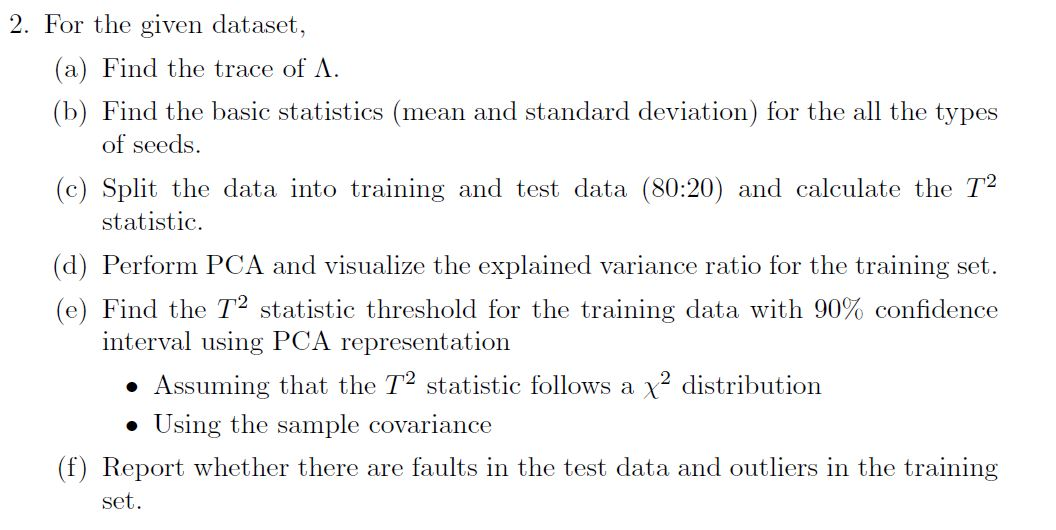

#### Importing Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

from scipy.stats import f
from scipy.stats import chi2

In [2]:
# Use seaborn style aesthetics
sns.set_style('darkgrid')

#### Common variable

In [3]:
scaler = StandardScaler()
dataset_whole = pd.read_csv('seeds.csv')
unique_type = np.unique(dataset_whole['Type'])
variance_consideration = 0.95
alpha_90 = 0.1   # 90% confidence level (10% significance level)
alpha_95 = 0.05  # 95% confidence level (5% significance level)
alpha_99 = 0.01  # 99% confidence level (1% significance level)
seed = 30

#### Common Functionality

In [4]:
def dataProcessing(dataset, scaler):
    """
    Preprocesses the dataset by dropping the 'Type' column, scaling the data, and returning both 
    the original and scaled datasets.

    Args:
        dataset (DataFrame): The input dataset.
        scaler (object): The scaler object for data scaling.

    Returns:
        dataset (DataFrame): The preprocessed original dataset.
        dataset_scale (ndarray): The scaled dataset.
    """
    # Drop the 'Type' column from the dataset
    dataset = dataset.drop('Type', axis=1)
    
    # Display descriptive statistics of the whole dataset
    display(dataset_whole.describe())
    
    # Display information about the dataset
    display(dataset_whole.info())
    
    # Fit the scaler on the dataset and transform the dataset
    #scaler.fit(dataset)
    dataset_scale = preprocessing.scale(dataset)    
    
    # Print the scaled dataset
    print(dataset_scale)
    
    return dataset, dataset_scale    

def eigendecomposition(dataset, meanshifting):
    """
    Performs eigendecomposition on the dataset, optionally applying mean shifting.

    Args:
        dataset (ndarray): The input dataset.
        meanshifting (bool): Whether to apply mean shifting.

    Returns:
        covarince_mat (ndarray): The covariance matrix.
        eigenvalues (ndarray): The eigenvalues.
        eigenvectors (ndarray): The eigenvectors.
    """
    # Apply mean shifting if meanshifting is True
    if meanshifting:
        dataset_meaned = (dataset - np.mean(dataset, axis=0))
    else:
        dataset_meaned = dataset        
    
    # Calculate the length of the dataset
    length = len(dataset_meaned)
    
    # Calculate the covariance matrix
    covarince_mat = (1/(length-1)) * (dataset_meaned.T @ dataset_meaned)
    
    # Display the covariance matrix
    display(covarince_mat)
    
    # Perform eigendecomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covarince_mat)
    
    # Print the shape of the covariance matrix, eigenvalues, and eigenvectors
    print("Covariance matrix shape:", covarince_mat.shape)
    print("Eigen Vector shape:", eigenvectors.shape)
    print("Eigen Value shape:", eigenvalues.shape)
    print("Eigen Vector:", eigenvectors)
    print("Eigen Value:", eigenvalues)
    
    return covarince_mat, eigenvalues, eigenvectors

def datasplitting(dataset, dataset_whole):
    """
    Splits the dataset into training and test sets.

    Args:
        dataset (DataFrame): The input dataset.
        dataset_whole (DataFrame): The complete dataset.

    Returns:
        X_train (DataFrame): The training features.
        X_test (DataFrame): The test features.
        y_train (Series): The training labels.
        y_test (Series): The test labels.
    """
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_whole['Type'], test_size=0.2, random_state=seed)
    
    return X_train, X_test, y_train, y_test

def tsquaredStat(eigenvalues, eigenvectors, data, dataset_type):
    """
    Calculates the T-squared statistic for each data point.

    Args:
        eigenvalues (ndarray): The eigenvalues.
        eigenvectors (ndarray): The eigenvectors.
        data (DataFrame): The input data.
        dataset_type (str): The type of dataset.

    Returns:
        Lambda (ndarray): The diagonal matrix of eigenvalues.
        t_squared_values (list): The list of T-squared values.
        sum_t_squared_val (float): The sum of T-squared values.
    """
    # Sort the eigenvalues and eigenvectors in descending order
    eigenvalue_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[eigenvalue_indices]
    eigenvectors_sorted = eigenvectors[:, eigenvalue_indices]
    Lambda = np.diag(eigenvalues_sorted)
    Lambda_inv = np.diag(1 / np.diag(Lambda)) #np.linalg.inv(Lambda)
    t_squared_values = []
    data_array = np.array(data)
    sum_t_squared_val = 0
    for i in range(len(data_array)):
        t_squared = 0
        data_loop = data_array[i, :].reshape(-1,1)
        t_squared = data_loop.T @ eigenvectors_sorted @ Lambda_inv @ eigenvectors_sorted.T @ data_loop
        sum_t_squared_val += t_squared
        t_squared_values.append(t_squared[0][0])     
    
    
    Z = ((np.linalg.inv(np.sqrt(Lambda))).dot(eigenvectors_sorted.T)).dot(data.T)
    T_squared = np.diag(Z.T@Z)    
    print('T Squared Values in a without PCA: \n', T_squared)
    
    # Print the dataset type
    print(f'{dataset_type} :')
    
    # Print the T-squared values
    print('T Squared Values with PCA: \n', t_squared_values)
    
    # Print the sum of T-squared values
    print('Sum of T Squared Values : ', sum_t_squared_val[0][0])
    
    return Lambda, t_squared_values, sum_t_squared_val[0][0]

def pc_required(explained_variances):
    '''
    Determine the explained variation in comparison to a predetermined threshold value, 
    and then provide the number of principle components to be chosen.
    '''   
    # Find the number of principal components that explain the desired variance threshold
    return np.argmax(np.cumsum(explained_variances) >= variance_consideration) + 1

def perform_PCA(input_data):
    """
    Performs Principal Component Analysis (PCA) on the input data.

    Args:
        input_data (ndarray): The input data.

    Returns:
        considerable_PC (int): The number of considerable principle components.
        input_data_transformed (ndarray): The transformed input data.
    """
    # Create a PCA object
    pca = PCA()

    # Fit the PCA model to the input data
    pca.fit(input_data)

    # Transform the input data using the PCA model
    input_data_transformed = pca.transform(input_data)

    # Obtain the explained variance ratio for each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Get the total number of principal components
    num_components = len(explained_variance_ratio)

    # Determine the number of considerable principle components based on a threshold
    considerable_PC = pc_required(explained_variance_ratio)

    # Print the number of total components and the number of considerable principle components
    print(f'Number of total component : {num_components}')
    print('Considerable Principle Component : ', considerable_PC)

    # Create a scree plot to visualize the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, num_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.xticks(np.arange(1, num_components + 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio for each principal component
    print("Explained Variance Ratio:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"Principal Component {i+1}: {ratio:.4f}")

    # Print the cumulative explained variance for each principal component
    print("\nCumulative Explained Variance:")
    for i, var in enumerate(cumulative_variance):
        print(f"Principal Components {i+1}: {var:.4f}")

    return considerable_PC, input_data_transformed, explained_variance_ratio

def statisticalAnalysis(inputdata, considerable_PC, transformed_data, alpha):
    """
    Performs statistical analysis on the transformed data.

    Args:
        inputdata (ndarray): The input data.
        considerable_PC (int): The number of considerable principle components.
        transformed_data (ndarray): The transformed data.
        alpha (float): The significance level.

    Returns:
        None
    """
    # Part 1 
    print('Part 1 : Assuming that the T2 statistic follows a χ2 distribution')
    # Calculate the T2 statistic threshold as per input alpha
    total_num_features = transformed_data.shape[1]
    print("Total Number of Features:", total_num_features)
    print('Considerable Principle Component : ', considerable_PC)
    
    # Degrees of freedom for the chi-square distribution
    dof = considerable_PC # number of Considerable Principle Component 
    print('Degree of Freedom', dof)

    # Calculate the T2 statistic threshold using the chi-square distribution    
    threshold = chi2.ppf(1 - alpha, df=dof)
    print("T2 Statistic Threshold:", threshold)


    # Part 2
    print('Part 2 : Using sample covariance')
    # Calculating T2 statistic threshold when sample covariance is used
    dfn = considerable_PC  # Degrees of freedom numerator
    dfd = inputdata.shape[0] - considerable_PC  # Degrees of freedom denominator

    # Calculate the critical value of F-distribution
    critical_value = f.ppf(1 - alpha, dfn, dfd)
    print("Critical value F_alpha(a, n-a):", critical_value)

    # Calculating T^2 statistic threshold
    n = inputdata.shape[0] - considerable_PC
    a = considerable_PC
    T_2_alpha = ((a * (n - 1) * (n + 1)) / (n * (n - a))) * critical_value
    print("T2 Statistic Threshold:", T_2_alpha)   
    
def outlier_threshold(alpha, input_data, considerablePC):
    """
    This function calculates the threshold for identifying outliers based on Hotelling's T-square 
    distribution and the F-distribution. This is used in multivariate outlier detection.

    Args:
    
    alpha : float
        The significance level for the F-distribution. This is used to control the Type I error 
        rate, i.e., the probability of falsely identifying an observation as an outlier.

    input_data : array-like
        A 2-dimensional numpy array or pandas DataFrame containing the multivariate data. Each 
        row represents an observation and each column represents a variable.

    considerablePC : int
        The number of principal components to be considered for outlier detection. This should be 
        less than or equal to the number of variables (columns) in the input data.

    Returns:
    
    float
        The threshold for identifying outliers. Observations with a T-square value greater than 
        this threshold are identified as outliers.    
    """
    n = input_data.shape[0]
    a = considerablePC
    f_alpha = f.ppf(1 - alpha, a, n - a - 1)    
    threshold_outlier= ((n - 1) ** 2 * (a / (n - a - 1)) * f_alpha) / (n * (1 + (a / (n - a - 1))))
    return threshold_outlier

def fault_threshold_method(alpha, input_data, considerablePC):
    """
    This function calculates the threshold for identifying fault based on Hotelling's T-square 
    distribution and the F-distribution. This is used in multivariate fault detection.

    Args:
    
    alpha : float
        The significance level for the F-distribution. This is used to control the Type I error 
        rate, i.e., the probability of falsely identifying an observation as an fault.

    input_data : array-like
        A 2-dimensional numpy array or pandas DataFrame containing the multivariate data. Each 
        row represents an observation and each column represents a variable.

    considerablePC : int
        The number of principal components to be considered for outlier detection. This should be 
        less than or equal to the number of variables (columns) in the input data.

    Returns:
    
    float
        The threshold for identifying faults. Observations with a T-square value greater than 
        this threshold are identified as faults.    
    """
    n = input_data.shape[0]
    a = considerablePC
    f_alpha = f.ppf(1 - alpha, a, n - a)
    fault_threshold_val = ((a*(n-1)*(n+1))/(n*(n-a)))*f_alpha
    return fault_threshold_val


def generate_ellipsoid(center, radii, rotation, num_points=100):
    """
    Generate points on an ellipsoid surface given the center, radii, and rotation matrix.

    Parameters:
        center (numpy.ndarray): The center point of the ellipsoid.
        radii (numpy.ndarray): The radii of the ellipsoid in the x, y, and z directions.
        rotation (numpy.ndarray): The rotation matrix for orienting the ellipsoid.
        num_points (int): The number of points to generate on the ellipsoid surface. Default is 100.

    Returns:
        numpy.ndarray: Array of shape (num_points, num_points, 3) containing the points on the ellipsoid surface.

    """

    # Generate angles u and v for parameterizing the ellipsoid surface
    u = np.linspace(0, 2 * np.pi, num_points)
    v = np.linspace(0, np.pi, num_points)

    # Calculate the x, y, and z coordinates for each point on the ellipsoid surface
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

    # Stack the x, y, and z coordinates to form the ellipsoid points array
    ellipsoid = np.stack((x, y, z), axis=-1)

    # Apply rotation and translation to each point on the ellipsoid surface
    for i in range(num_points):
        for j in range(num_points):
            ellipsoid[i, j] = np.dot(rotation, ellipsoid[i, j]) + center

    # Return the array of points on the ellipsoid surface
    return ellipsoid


def OutlierAndFaultAnalysis(dataset_whole, seed_type, alpha):
    """
    Perform outlier analysis and fault analysis on the Seeds dataset for a specific seed type.

    Args:
        dataset_whole (DataFrame): The entire Seeds dataset containing all samples and features.
        seed_type (int): The seed type for which to perform outlier and fault analysis.

    Returns:
        None (Displays various plots and printed results.)
    """

    # Segregating data
    x_dataset = dataset_whole.drop('Type', axis=1)
    y_dataset = dataset_whole['Type']
    type_dataset = dataset_whole[dataset_whole['Type'] == seed_type]
    x_type_dataset = type_dataset.drop('Type', axis=1)
    y_type_dataset = type_dataset['Type']

    # Splitting the data
    X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(x_type_dataset, y_type_dataset, test_size=0.2, random_state=seed)

    # Scaling the data
    X_train_type_scaled = preprocessing.scale(X_train_type)
    
    # Plot 1 - Original and Scaled Train Data Histograms
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(np.array(X_train_type).flatten(), bins=20, color='blue', alpha=0.5)
    axes[0].set_title('Original Train Data')
    axes[1].hist(np.array(X_train_type_scaled).flatten(), bins=20, color='red', alpha=0.5)
    axes[1].set_title('Autoscaled Train Data')
    plt.tight_layout()
    plt.show()

    # Outlier Analysis - PCA
    pca = PCA()
    pca.fit(X_train_type_scaled)
    X_train_type_scaled_transformed = pca.transform(X_train_type_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    num_components = len(explained_variance_ratio)
    considerable_PC = pc_required(explained_variance_ratio)
    print(f'Number of total component : {num_components}')
    print('Considerable Principle Component : ', considerable_PC)
    
    # Scree Plot
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, num_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.xticks(np.arange(1, num_components + 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio for each principal component
    print("Explained Variance Ratio:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"Principal Component {i+1}: {ratio:.4f}")

    # Print the cumulative explained variance for each principal component
    print("\nCumulative Explained Variance:")
    for i, var in enumerate(cumulative_variance):
        print(f"Principal Components {i+1}: {var:.4f}")
    
    
    # Eigen Value Decomposition
    meanshifting = True
    if meanshifting:
        dataset_meaned = (X_train_type_scaled - np.mean(X_train_type_scaled, axis=0))
    else:
        dataset_meaned = X_train_type_scaled
    # Calculate the length of the dataset
    length = len(dataset_meaned)
    # Calculate the covariance matrix
    covarince_mat = (1/(length-1)) * (dataset_meaned.T @ dataset_meaned)
    # Display the covariance matrix
    display(covarince_mat)
    # Perform eigendecomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covarince_mat)
    # Print the shape of the covariance matrix, eigenvalues, and eigenvectors
    print("Covariance matrix shape:", covarince_mat.shape)
    print("Eigen Vector shape:", eigenvectors.shape)
    print("Eigen Value shape:", eigenvalues.shape)
    print("Eigen Vector:", eigenvectors)
    print("Eigen Value:", eigenvalues)
    
    #Sorting and ordering 
    eigenvalue_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[eigenvalue_indices]
    eigenvectors_sorted = eigenvectors[:, eigenvalue_indices]
    Lambda = np.diag(eigenvalues_sorted)
    Lambda_inv = np.diag(1 / np.diag(Lambda)) #np.linalg.inv(Lambda)
    print(f'Lambda : {Lambda} & Lambda Incerse : {Lambda_inv}')
    
    #TSquared Statistics Calculation
    TSquaredStatistics=[]
    for loop_i in range(len(X_train_type_scaled)):
        TSquaredStatistics.append(X_train_type_scaled[loop_i].T@eigenvectors_sorted[:,:considerable_PC]@Lambda_inv[:considerable_PC,:considerable_PC]@eigenvectors_sorted[:,:considerable_PC].T@X_train_type_scaled[loop_i])
    TSquaredStatistics=np.array(TSquaredStatistics)
    print(f'T_squared statistic : {TSquaredStatistics}')
    
    #Outlier Threshold 
    type_outlier_threshold = outlier_threshold(alpha_90, X_train_type_scaled, considerable_PC)
    print(f'Outlier Threhold : {type_outlier_threshold}')
    
    #Plot 1    
    pca = PCA(n_components=considerable_PC)
    x_dataset_pca = pca.fit_transform(x_dataset)
    y_labels = y_dataset
    custom_palette = sns.color_palette('viridis', len(np.unique(y_labels)))
    type_indices = np.where(y_labels == seed_type)[0]
    type_data = x_dataset_pca[type_indices, :]
    threshold = chi2.ppf(1 - alpha, df=considerable_PC)
    sns.scatterplot(x=x_dataset_pca[:, 0], y=x_dataset_pca[:, 1], palette=custom_palette, hue=y_labels, s=80, alpha=0.7)
    # Adding the T2 threshold ellipse for seed type data
    ellipse = Ellipse(xy=np.mean(type_data, axis=0), width=2 * np.sqrt(threshold) * np.sqrt(pca.explained_variance_ratio_[0]),
                      height=2 * np.sqrt(type_outlier_threshold) * np.sqrt(pca.explained_variance_ratio_[1]), edgecolor='red', facecolor='none',
                      label=f'{seed_type} $T^2$ Threshold')

    # Adding the ellipse to the plot
    plt.gca().add_patch(ellipse)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
    plt.title(f'PCA of Seeds Dataset for {seed_type}', fontsize=16)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot 2 - Outlier Boundary for Seeds Dataset in 3D
    PCs = eigenvectors_sorted[:, :considerable_PC].T @ X_train_type_scaled.T
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(xs=PCs[0, :].T, ys=PCs[1, :].T, zs=PCs[2, :].T, c=np.array(y_train_type).reshape(-1),
                         cmap='Set1', s=50, edgecolor='white', alpha=0.7)
    ax.set_box_aspect([1, 1, 1])
    center = np.mean(np.array([PCs[0, :].T, PCs[1, :].T, PCs[2, :].T]), axis=1)
    radii = 2 * np.sqrt(type_outlier_threshold) * np.sqrt(explained_variance_ratio)
    rotation = np.eye(3)
    ellipsoid_points = generate_ellipsoid(center, radii, rotation)
    ax.plot_surface(ellipsoid_points[..., 0], ellipsoid_points[..., 1], ellipsoid_points[..., 2],
                    edgecolor='green', linewidth=1, alpha=0.2, color='lightgray')
    ax.scatter(center[0], center[1], center[2], marker='*', color='yellow', s=100, edgecolor='black')
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.set_zlabel('PC3', fontsize=12)
    ax.set_title(f'Outlier Boundary for Seeds Dataset in 3D of type {seed_type}', fontsize=16)
    cbar = fig.colorbar(scatter)
    cbar.set_label('Class', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    # Fault Analysis
    X_test_type_scaled = preprocessing.scale(X_test_type)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(np.array(X_test_type).flatten(), bins=20, color='blue', alpha=0.5)
    axes[0].set_title('Original Test Data')
    axes[1].hist(np.array(X_test_type_scaled).flatten(), bins=20, color='red', alpha=0.5)
    axes[1].set_title('Autoscaled Test Data')
    plt.tight_layout()
    plt.show()

    # Fault Threshold Calculation
    type_fault_threshold = fault_threshold_method(alpha_90, X_test_type_scaled, considerable_PC)
    print(f'Fault Threhold : {type_fault_threshold}')
    
    TSquaredStatistics_Fault=[]
    for loop_fault in range(len(X_test_type_scaled)):
        TSquaredStatistics_Fault.append(X_test_type_scaled[loop_fault].T@eigenvectors_sorted[:,:considerable_PC]@Lambda_inv[:considerable_PC,:considerable_PC]@eigenvectors_sorted[:,:considerable_PC].T@X_test_type_scaled[loop_fault])
    TSquaredStatistics_Fault=np.array(TSquaredStatistics_Fault)
    print(f"T_squared statistic", TSquaredStatistics_Fault,"\n\n")
    
    # Plot 3
    PCs = np.array(eigenvectors_sorted[:, :considerable_PC].T @ X_test_type_scaled.T)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(xs=PCs[0, :].T, ys=PCs[1, :].T, zs=PCs[2, :].T, c=np.array(y_test_type).reshape(-1),
                         cmap='Set1', s=50, edgecolor='white', alpha=0.7)
    ax.set_box_aspect([1, 1, 1])
    center = np.mean(np.array([PCs[0, :].T, PCs[1, :].T, PCs[2, :].T]), axis=1)
    radii = 2 * np.sqrt(type_fault_threshold) * np.sqrt(explained_variance_ratio)
    rotation = np.eye(3)
    ellipsoid_points = generate_ellipsoid(center, radii, rotation)
    ax.plot_surface(ellipsoid_points[..., 0], ellipsoid_points[..., 1], ellipsoid_points[..., 2],
                    edgecolor='green', linewidth=1, alpha=0.2, color='lightgray')
    ax.scatter(center[0], center[1], center[2], marker='*', color='yellow', s=100, edgecolor='black')
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.set_zlabel('PC3', fontsize=12)
    ax.set_title(f'Fault Boundary for Seeds Dataset in 3D of type {seed_type}', fontsize=16)
    cbar = fig.colorbar(scatter)
    cbar.set_label('Class', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    


#### Data Loading & Processing

In [5]:
dataset, dataset_scale = dataProcessing(dataset_whole, scaler)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,14.918744,14.595829,0.870811,5.643151,3.265533,3.699217,5.420653,1.994975
std,2.919976,1.310445,0.023320,0.443593,0.378322,1.471102,0.492718,0.813382
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.330000,13.470000,0.857100,5.267000,2.954500,2.570000,5.046000,1.000000
50%,14.430000,14.370000,0.873400,5.541000,3.245000,3.631000,5.228000,2.000000
75%,17.455000,15.805000,0.886800,6.002000,3.564500,4.799000,5.879000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.315000,6.550000,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

[[ 0.11716431  0.18679667  0.0081443  ...  0.12313474 -1.00737062
  -0.40826475]
 [-0.01330197 -0.01975993  0.44234139 ...  0.17878306 -1.82718718
  -0.9454197 ]
 [-0.21586804 -0.38697165  1.46979786 ...  0.18938275 -0.68162472
  -1.21196249]
 ...
 [-0.59010028 -0.71593216  0.75186803 ... -0.08885888  3.14554887
  -0.74195192]
 [-1.05703224 -1.06019315 -0.80436312 ... -1.13822732 -0.06897709
  -0.76636805]
 [-0.89909937 -0.96073998 -0.10362921 ... -0.77253832  1.32055406
  -0.72770917]]


#### Visualization of the dataset

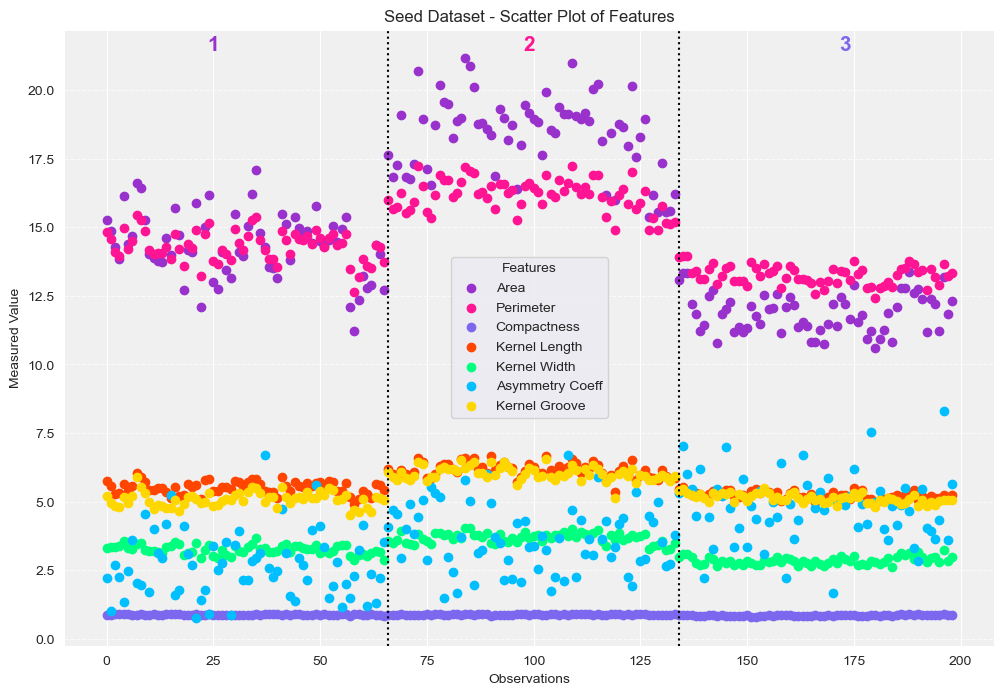

In [6]:
# Define the features and their labels
features = {
    'Area': 'Area',
    'Perimeter': 'Perimeter',
    'Compactness': 'Compactness',
    'Kernel.Length': 'Kernel Length',
    'Kernel.Width': 'Kernel Width',
    'Asymmetry.Coeff': 'Asymmetry Coeff',
    'Kernel.Groove': 'Kernel Groove',
}

# Create a single plot for all features
plt.figure(figsize=(12, 8))

# Set custom colors for the scatter plots
colors = ['#9932CC', '#FF1493', '#7B68EE', '#FF4500', '#00FF7F', '#00BFFF', '#FFD700']

# Iterate through the features and plot scatter plots with custom colors and markers
for i, (feature, label) in enumerate(features.items()):
    plt.scatter(dataset_whole.index, dataset_whole[feature], label=label, color=colors[i], marker='o')

# Add legends and labels
plt.legend(title='Features', loc = 'center')
plt.xlabel('Observations')
plt.ylabel('Measured Value')
plt.title('Seed Dataset - Scatter Plot of Features')

# Draw dotted lines to separate classes
for index in [66, 134]:
    plt.axvline(index, color='black', linestyle='dotted')

# Add class labels
class_labels = ['1', '2', '3']
for i, label in enumerate(class_labels):
    plt.text(25 + i * 74, 22, label, ha='center', va='top', color=colors[i], fontweight='bold', fontsize = 15)

# Customize grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize background color
plt.gca().set_facecolor('#f0f0f0')

# Show the plot
plt.show()


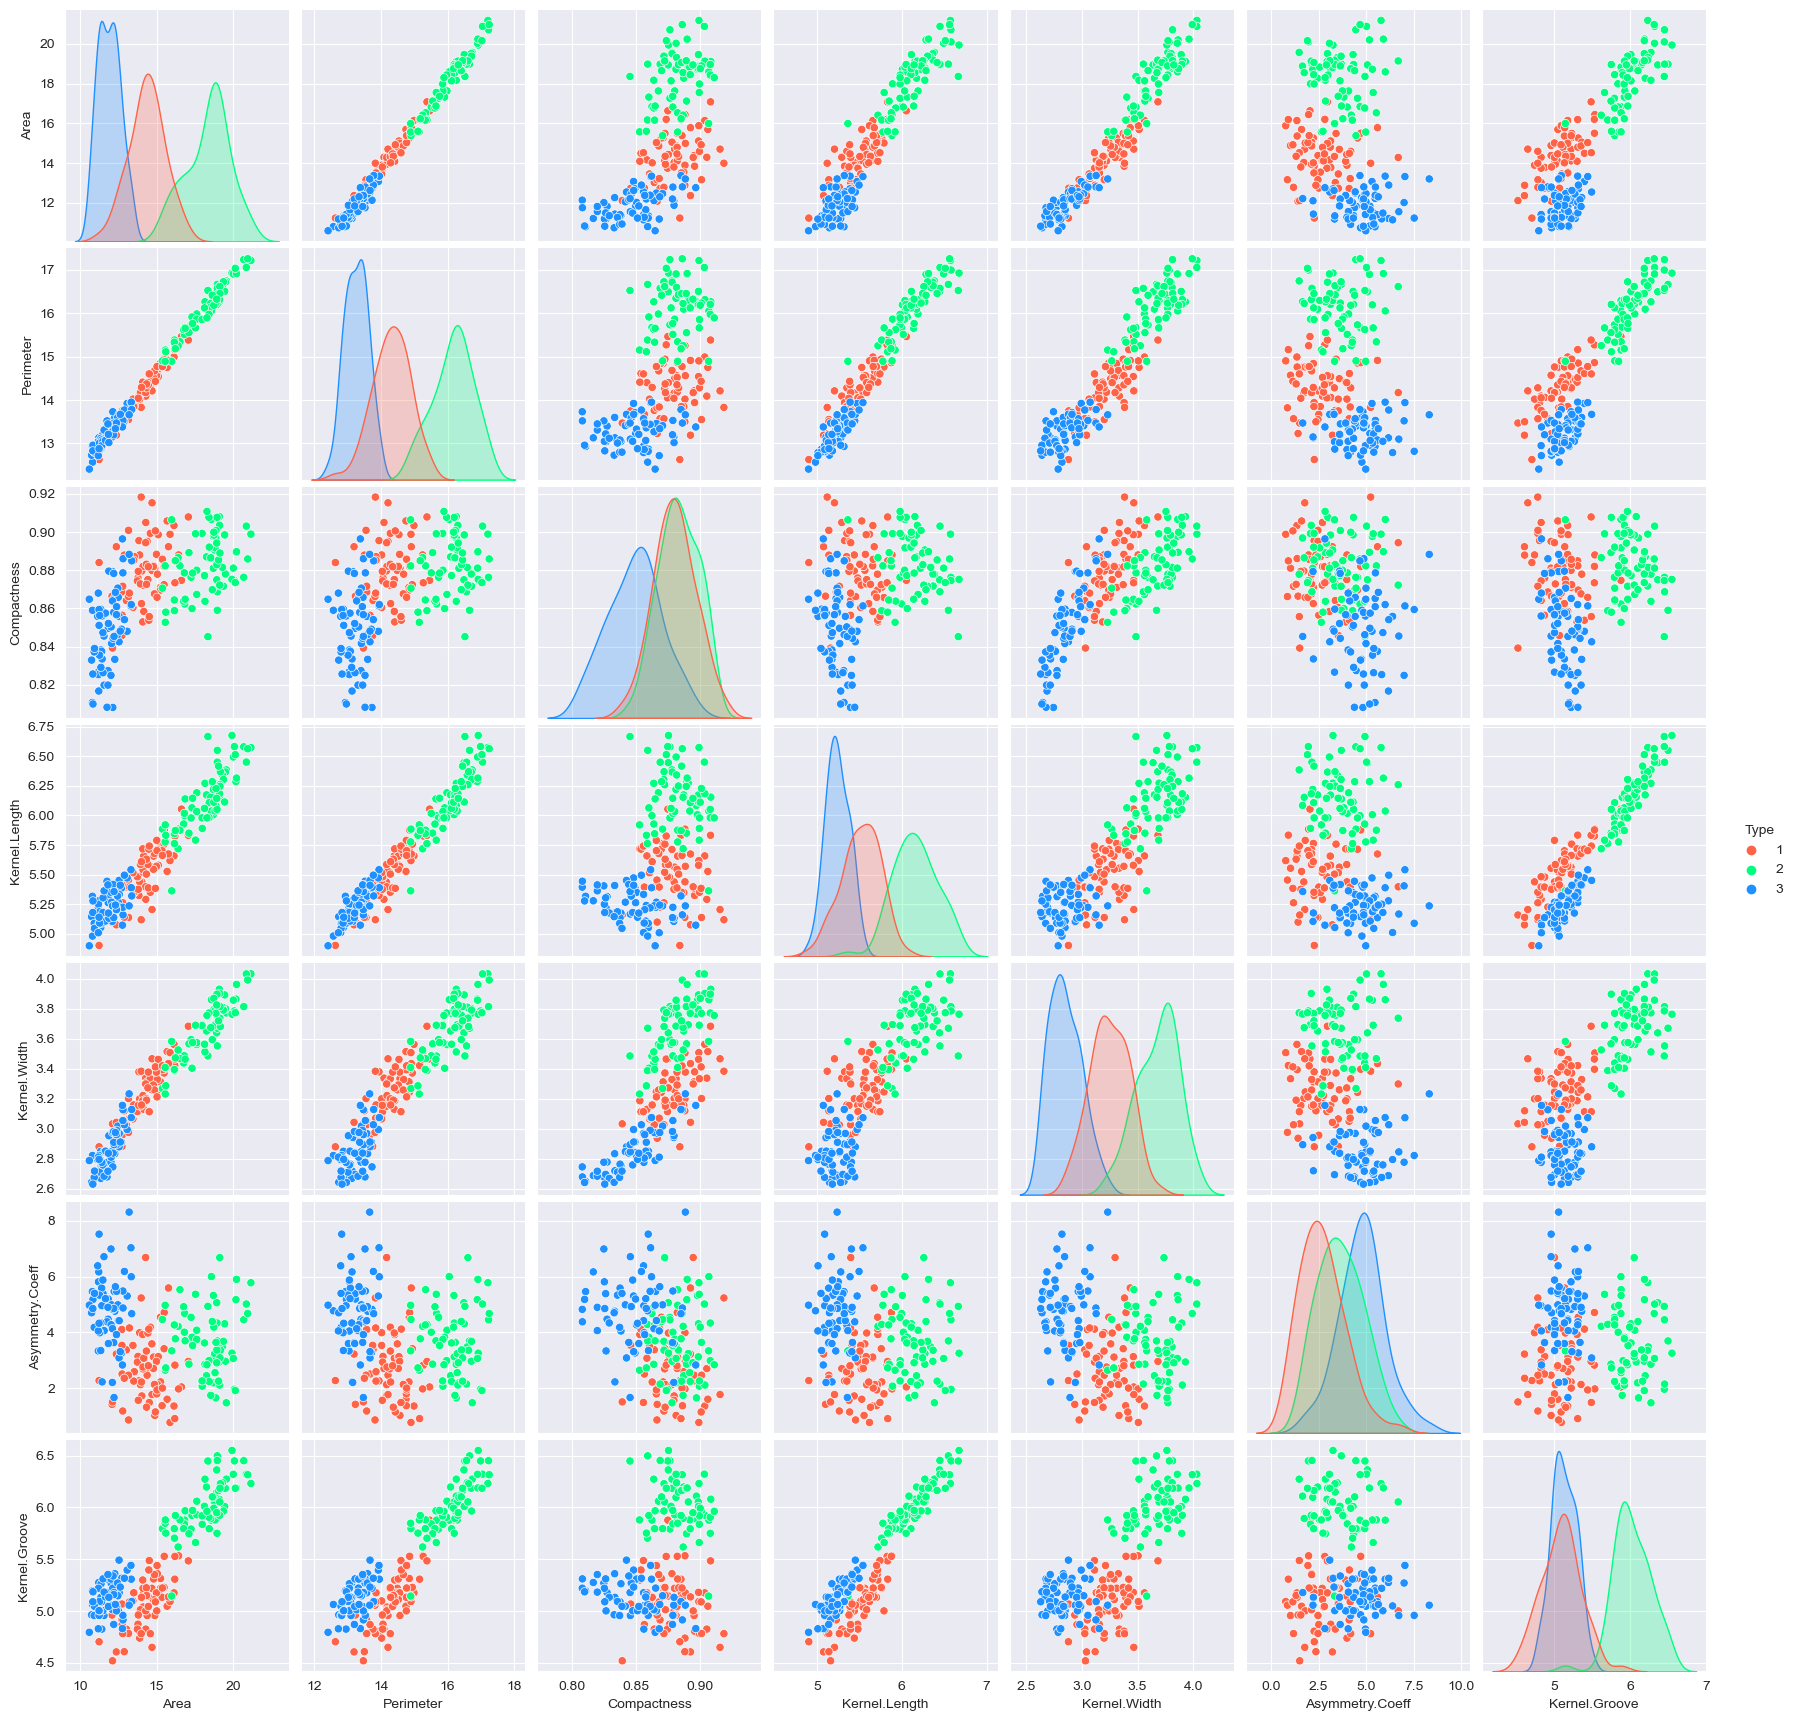

In [7]:
custom_palette = ['#FF6347', '#00FF7F', '#1E90FF']
sns.pairplot(dataset_whole, hue='Type', palette=custom_palette)
plt.show()

## a) Find the trace of Λ.

In [8]:
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(dataset_scale, True)

array([[ 1.00505051,  0.99945967,  0.61296771,  0.95592951,  0.97588352,
        -0.22394581,  0.86708441],
       [ 0.99945967,  1.00505051,  0.5345268 ,  0.97785806,  0.95027092,
        -0.21210008,  0.89403606],
       [ 0.61296771,  0.5345268 ,  1.00505051,  0.3759002 ,  0.7660163 ,
        -0.33106381,  0.22816301],
       [ 0.95592951,  0.97785806,  0.3759002 ,  1.00505051,  0.8670369 ,
        -0.17056152,  0.9368318 ],
       [ 0.97588352,  0.95027092,  0.7660163 ,  0.8670369 ,  1.00505051,
        -0.25440081,  0.75200687],
       [-0.22394581, -0.21210008, -0.33106381, -0.17056152, -0.25440081,
         1.00505051, -0.00336631],
       [ 0.86708441,  0.89403606,  0.22816301,  0.9368318 ,  0.75200687,
        -0.00336631,  1.00505051]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 0.44444526  0.0268951  -0.02541939  0.19763627  0.19751625 -0.73412145
  -0.42905925]
 [ 0.44156742  0.08298812  0.06019769  0.30034829  0.16637062  0.67153918
  -0.47503082]
 [ 0.27791499 -0.52535969 -0.63238211 -0.34000075 -0.32627308  0.07310414
  -0.13947927]
 [ 0.42412605  0.200075    0.21443932  0.25098045 -0.76832639 -0.0463691
   0.28042137]
 [ 0.43293659 -0.11572453 -0.2151238   0.20373132  0.46870015  0.03700686
   0.70024261]
 [-0.1157433   0.72122562 -0.67513087  0.09326364 -0.04045161  0.00383945
  -0.01691821]
 [ 0.38669933  0.37788656  0.21853787 -0.80120818  0.12333864  0.0349609
   0.03920887]]
Eigen Value: [5.05691778e+00 1.20519035e+00 6.79631565e-01 6.85475795e-02
 1.89074688e-02 8.16380060e-04 5.34241202e-03]


In [9]:
trace_scale = np.trace(np.diag(eigenvalues_scale))
print("Trace of Λ with scalling:", trace_scale)

Trace of Λ with scalling: 7.035353535353538


###  Conclusion of a)

###### We have clauclated trace of Λ derived from the scaled data using eigen value decomposition. In a scalled data trace is appear as approximately 7.035.

## b) Find the basic statistics (mean and standard deviation) for the all the types of seeds.

In [10]:
unique_type

array([1, 2, 3], dtype=int64)

#### Five summary table for individual seeds type

In [11]:
# Group the data by seed type
grouped_data = dataset_whole.groupby('Type')
print(grouped_data)
df_groupdata_stats = grouped_data.describe()
display(grouped_data.describe())
df_groupdata_stats.to_csv('groupwiseStat.csv', sep=',', index=False, encoding='utf-8')

Area                                                            \
     count       mean       std    min    25%    50%      75%    max   
Type                                                                   
1     66.0  14.354394  1.178117  11.23  13.75  14.36  15.0450  17.08   
2     68.0  18.370147  1.413670  15.38  17.35  18.72  19.1425  21.18   
3     65.0  11.881077  0.720822  10.59  11.27  11.84  12.3800  13.37   

     Perimeter             ... Asymmetry.Coeff        Kernel.Groove            \
         count       mean  ...             75%    max         count      mean   
Type                       ...                                                  
1         66.0  14.306818  ...         3.36175  6.685          66.0  5.087197   
2         68.0  16.156912  ...         4.45375  6.682          68.0  6.026515   
3         65.0  13.256154  ...         5.46200  8.315          65.0  5.125415   

                                                       
           std    min     25%     50%      75%    max  
Type                                                   
1     0.259822  4.519  4.9245  5.0940  5.22150  5.877  
2     0.246663  5.144  5.8785  5.9815  6.18725  6.550  
3     0.160033  4.794  5.0030  5.1320  5.26300  5.491  

[3 rows x 56 columns]

##### Mean of the dataset

In [12]:
#Mean information separately 
print(f'Mean of the given data based on type :')
grouped_data.mean()

Mean of the given data based on type :


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Type,,,,,,,
1,14.354394,14.306818,0.879892,5.513000,3.247485,2.690670,5.087197
2,18.370147,16.156912,0.882965,6.157838,3.678647,3.657250,6.026515
3,11.881077,13.256154,0.848874,5.236862,2.851677,4.767185,5.125415


##### Standard deviation of the dataset

In [13]:
#standard deviation information separately 
print(f'Standard Deviation of the given data based on type :')
grouped_data.std()

Standard Deviation of the given data based on type :


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Type,,,,,,,
1,1.178117,0.559209,0.016349,0.228527,0.173251,1.198981,0.259822
2,1.413670,0.599224,0.015371,0.259336,0.185824,1.195293,0.246663
3,0.720822,0.347975,0.020807,0.136917,0.143343,1.237093,0.160033


###  Conclusion of b)

###### Basic statistical analysis has been done on the entire data. Initially we have calculated the 5 point summary table for each type in the main dataset and next as per the request we have separately display the mean and standard deviation for each type of the seed.

## c) Split the data into training and test data (80:20) and calculate the T2 statistic.

<h4 style='text-align: center;'> Formulation using PCA $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$</h4>
<h4 style='text-align: center;'> Formulation without PCA $z = \Lambda^{-1/2}V^{T}x$, $T^{2} = z^{T}z$</h4>

In [14]:
X_train_scale, X_test_scale, y_train_scale, y_test_scale = datasplitting(dataset_scale, dataset_whole)

In [15]:
print("Scaled Training data shape:", X_train_scale.shape)
print("Scaled Test data shape:", X_test_scale.shape)

Scaled Training data shape: (159, 7)
Scaled Test data shape: (40, 7)


##### Analysis on train dataset

In [16]:
print('Analysis on Train dataset : ')
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(X_train_scale, True)
Lambda_train_scale, t_squared_values_train_scale, sum_t_squared_values_train_scale = tsquaredStat(eigenvalues_scale, eigenvectors_scale, X_train_scale, 'Scale Train Dataset')

Analysis on Train dataset : 


array([[ 0.96998048,  0.96334701,  0.59931379,  0.92219736,  0.95218448,
        -0.19894364,  0.82316815],
       [ 0.96334701,  0.96850848,  0.51743217,  0.94448966,  0.92483881,
        -0.18570187,  0.85134023],
       [ 0.59931379,  0.51743217,  1.01555981,  0.3575976 ,  0.76355007,
        -0.33623986,  0.19297432],
       [ 0.92219736,  0.94448966,  0.3575976 ,  0.97394067,  0.84478869,
        -0.14487271,  0.89443549],
       [ 0.95218448,  0.92483881,  0.76355007,  0.84478869,  0.99130419,
        -0.23276407,  0.71876968],
       [-0.19894364, -0.18570187, -0.33623986, -0.14487271, -0.23276407,
         1.01922112,  0.0104037 ],
       [ 0.82316815,  0.85134023,  0.19297432,  0.89443549,  0.71876968,
         0.0104037 ,  0.95110651]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 0.4446199   0.0302841  -0.02601202  0.17782854  0.25661405 -0.72410249
  -0.42299081]
 [ 0.44110619  0.08797006  0.06025852  0.29272503  0.23821032  0.68145179
  -0.43272032]
 [ 0.2826643  -0.53341971 -0.62037301 -0.31025567 -0.34112073  0.08034061
  -0.17783444]
 [ 0.42370744  0.2026861   0.21185989  0.31944064 -0.7647388  -0.05492641
   0.211237  ]
 [ 0.43846746 -0.11065527 -0.21472648  0.13818673  0.41658418  0.01813921
   0.74594052]
 [-0.11016562  0.71878068 -0.68113547  0.07559293 -0.03357756  0.00527387
  -0.02006947]
 [ 0.37936947  0.36991302  0.23641493 -0.81214426  0.03932502  0.03834948
   0.02749006]]
Eigen Value: [4.87621224e+00 1.23797670e+00 6.89879269e-01 6.26560732e-02
 1.72535017e-02 8.33788927e-04 4.80969208e-03]
T Squared Values in a without PCA: 
 [ 8.13882491  1.23670108 21.09492629  8.92054082  5.02947442 11.69291696
  4.60229843  6.64995453  7.24398194  5.55438987

##### Analysis on test dataset

As per general process to calculate the T-squared value using PCA:

- Perform PCA on the training data to obtain the eigenvectors and eigenvalues.
- Calculate the T-squared statistic for each observation in the test data using the eigenvectors and eigenvalues obtained from PCA.

In [17]:
Lambda_test_scale, t_squared_values_test_scale, sum_t_squared_values_test_scale = tsquaredStat(eigenvalues_scale, eigenvectors_scale, X_test_scale, 'Scale Test Dataset')

T Squared Values in a without PCA: 
 [17.97155017  6.80592556  5.50127547  5.65725954  8.0396095   5.77217545
  4.03445262  3.00241146 12.54252833  7.28318068 13.18650766  7.50862326
  6.23381861  7.29001726 10.64162135  5.91240681  6.922252    4.73017239
 18.87708884  3.48900462  9.51545672  1.25711585  9.67187523  5.48889851
  4.70654293  3.84898714  4.94566494  7.53919448  2.80443316 14.37988432
  8.43320372 58.59438464  2.75988509  6.66049781 13.20741235  5.46526952
  7.69906123  5.23101903  6.84047085  7.85321699]
Scale Test Dataset :
T Squared Values with PCA: 
 [17.971550165014854, 6.805925558256483, 5.501275471155701, 5.657259544247429, 8.039609503680417, 5.772175453332268, 4.034452621218396, 3.0024114593468343, 12.542528330103499, 7.2831806768427, 13.186507664826166, 7.508623255239154, 6.233818606354115, 7.290017257839727, 10.641621352936081, 5.912406812535059, 6.922252002986429, 4.730172393957201, 18.877088836442873, 3.489004622573003, 9.515456722511141, 1.2571158509818683, 9

###  Conclusion of c)
##### We have analyze the T squared statistics on the scaled data after splitting them into train and test set. In first cell we have given the report for train dataset and in next cell same report has been given for test dataset.
We have calculated the T Squared statistics using below two possible way,
- **Using PCA** : Using PCA method we have find out the eigen value and vector of the covariance matrix of the dataset and then perfom T Squared calculating using $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$.
- **Without using PCA** : In this method without PCA we are using $z = \Lambda^{-1/2}V^{T}x$, $T^{2} = z^{T}z$ formulation to calculate the same.

##### Using both the formulation we are getting same value as the T Squared statistics.

##### Moreover on test dataset we are following below in general consideration,
- Calculate the T-squared statistic for each observation in the test data using the eigenvectors and eigenvalues obtained from PCA of Train data

## d)  Perform PCA and visualize the explained variance ratio for the training set.

Number of total component : 7
Considerable Principle Component :  3


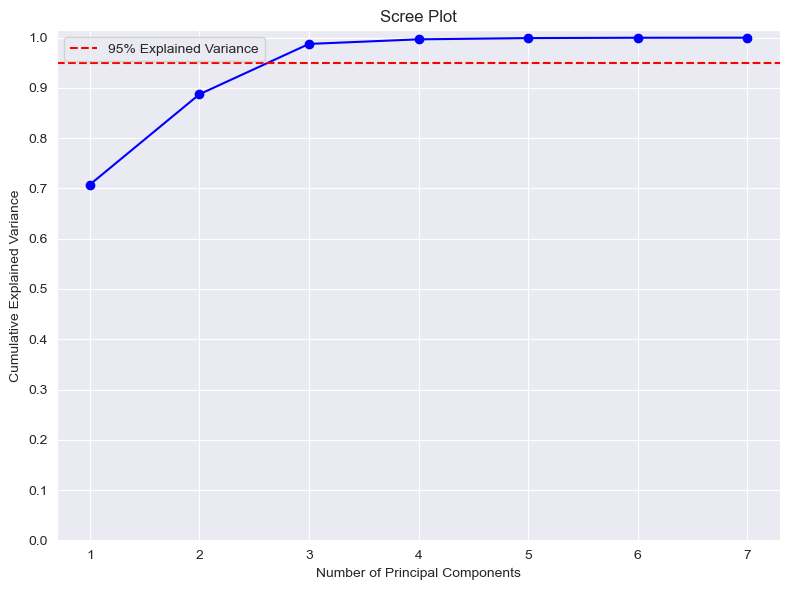

Explained Variance Ratio:
Principal Component 1: 0.7078
Principal Component 2: 0.1797
Principal Component 3: 0.1001
Principal Component 4: 0.0091
Principal Component 5: 0.0025
Principal Component 6: 0.0007
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1: 0.7078
Principal Components 2: 0.8874
Principal Components 3: 0.9876
Principal Components 4: 0.9967
Principal Components 5: 0.9992
Principal Components 6: 0.9999
Principal Components 7: 1.0000


(3,
 array([[ 2.91227405,  0.78722967,  0.42897615, ..., -0.02472031,
         -0.05352962,  0.00722962],
        [-1.20394502,  0.07443273,  0.25963188, ..., -0.06520818,
         -0.00970153, -0.01526807],
        [ 2.89880671, -2.54645106, -1.09249702, ..., -0.43710109,
          0.02350067, -0.02691593],
        ...,
        [-1.97989981, -0.48594054,  0.2770536 , ..., -0.01557391,
         -0.02190397, -0.00569306],
        [-3.18433125, -1.82110649, -1.02961763, ...,  0.12881505,
          0.16043915,  0.04483931],
        [-0.60008419, -0.46027835,  2.30203398, ..., -0.11540018,
         -0.06251794, -0.02797115]]),
 array([7.07762017e-01, 1.79687192e-01, 1.00133119e-01, 9.09426960e-03,
        2.50427433e-03, 6.98106891e-04, 1.21021010e-04]))

In [18]:
perform_PCA(X_train_scale)

###  Conclusion of d)
##### We are performing the PCA on a train dataset and based on the eigen values we have caluclated the explained variance for each principle component and plotted. While finalizing the minimum considerable principle components need to keep for further reconstruction we have considered to maintain 95% explained variance as a threshold. Considering the same we have got minimum 3 principle components should be reserve for further resconstruction. 

### e)  Find the T2 statistic threshold for the training data with 90% confidence interval using PCA representation
- Assuming that the T2 statistic follows a χ2 distribution
- Using the sample covariance

### Formulation 
<h4 style='text-align: center;'> T Squared threshold when actual covariance matrix is estimated from sample covariance :  $\frac{a(n-1)(n+1)F_{\alpha}}{n(n-a)}$ </h4>

Number of total component : 7
Considerable Principle Component :  3


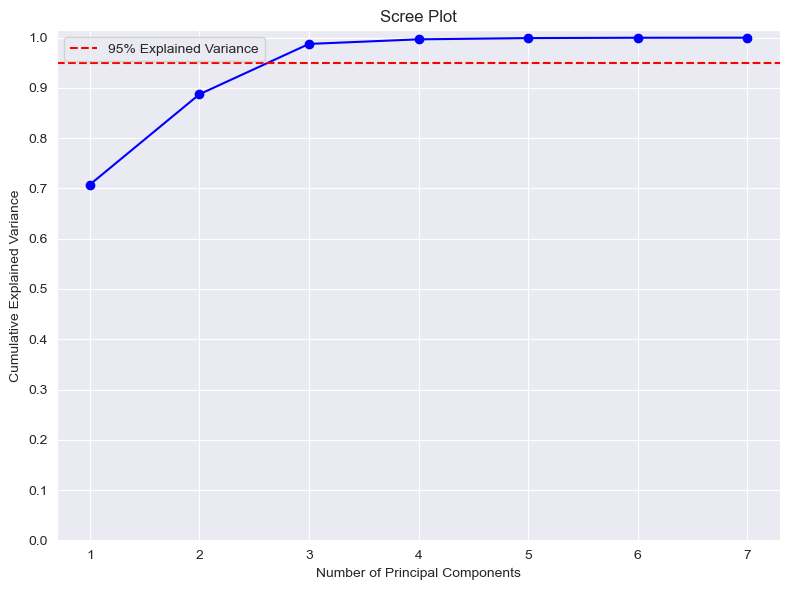

Explained Variance Ratio:
Principal Component 1: 0.7078
Principal Component 2: 0.1797
Principal Component 3: 0.1001
Principal Component 4: 0.0091
Principal Component 5: 0.0025
Principal Component 6: 0.0007
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1: 0.7078
Principal Components 2: 0.8874
Principal Components 3: 0.9876
Principal Components 4: 0.9967
Principal Components 5: 0.9992
Principal Components 6: 0.9999
Principal Components 7: 1.0000


In [19]:
considerable_PC_scale, transformed_data_scale, variance_explained_ratio_scale = perform_PCA(X_train_scale)

In [20]:
print('Conclusion :')
print('Result with scale data : ')
statisticalAnalysis(X_train_scale, considerable_PC_scale, transformed_data_scale, alpha_90) 

Conclusion :
Result with scale data : 
Part 1 : Assuming that the T2 statistic follows a χ2 distribution
Total Number of Features: 7
Considerable Principle Component :  3
Degree of Freedom 3
T2 Statistic Threshold: 6.251388631170325
Part 2 : Using sample covariance
Critical value F_alpha(a, n-a): 2.1192236622197966
T2 Statistic Threshold: 6.482064834102407


###  Conclusion of e) 
##### We have performed the analysis on scaled train data of the given dataset. The problem statement has two assumption to made. 
- Assuming that the T2 statistic follows a χ2 distribution
- Using sample covariance

As per the assumption and considering that there are only 3 considerable principle components we have achieved the threshold as below,

- **Assuming that the T2 statistic follows a χ2 distribution**
    - T2 Statistic Threshold: 6.251388631170325
- **Using sample covariance**
    - T2 Statistic Threshold: 6.482064834102407

### f) Report whether there are faults in the test data and outliers in the training set.

### Outlier Detection : -
### Formulation:
<div align='center'> Outliers in the training set can be detected using the $T^{2}$ statistic for a selected confidence level = $\frac{(n-1)^{2}(a/(n-a-1))F_{\alpha}(a, n-a-1)}{n(1+(a/(n-a-1)))}$   

We have calculated the T Squared statistics using below two possible way,
- **Using PCA** : Using PCA method we have find out the eigen value and vector of the covariance matrix of the dataset and then perfom T Squared calculating using $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$.
- **Without using PCA** : In this method without PCA we are using $z = \Lambda^{-1/2}V^{T}x$, $T^{2} = z^{T}z$ formulation to calculate the same.

### Fault Identification : -

### Formulation:
<div align='center'> Faults in the test set can be detected using the $T^{2}$ statistic for a selected confidence level = $\frac{a(n-1)(n+1)F_{\alpha}}{n(n-a)}$z
   

We have calculated the T Squared statistics using below two possible way,
- **Using PCA** : Using PCA method we have find out the eigen value and vector of the covariance matrix of the dataset and then perfom T Squared calculating using $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$.
- **Without using PCA** : In this method without PCA we are using $z = \Lambda^{-1/2}V^{T}x$, $T^{2} = z^{T}z$ formulation to calculate the same.

#### For Type 1 - Fault & Outlier Analysis

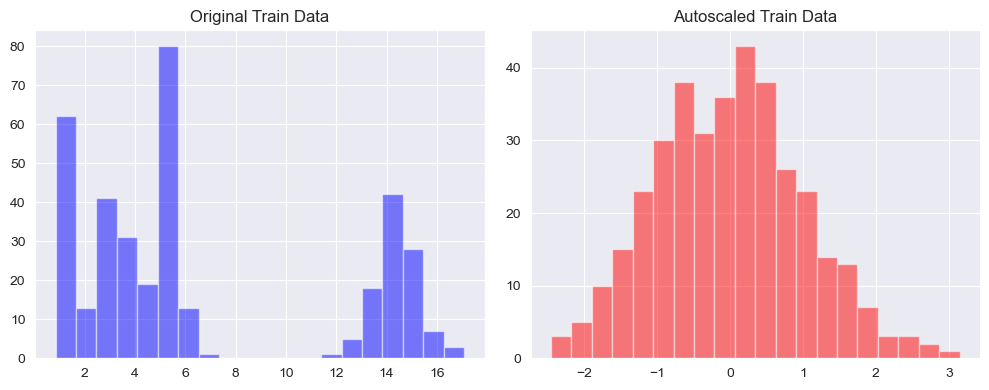

Number of total component : 7
Considerable Principle Component :  3


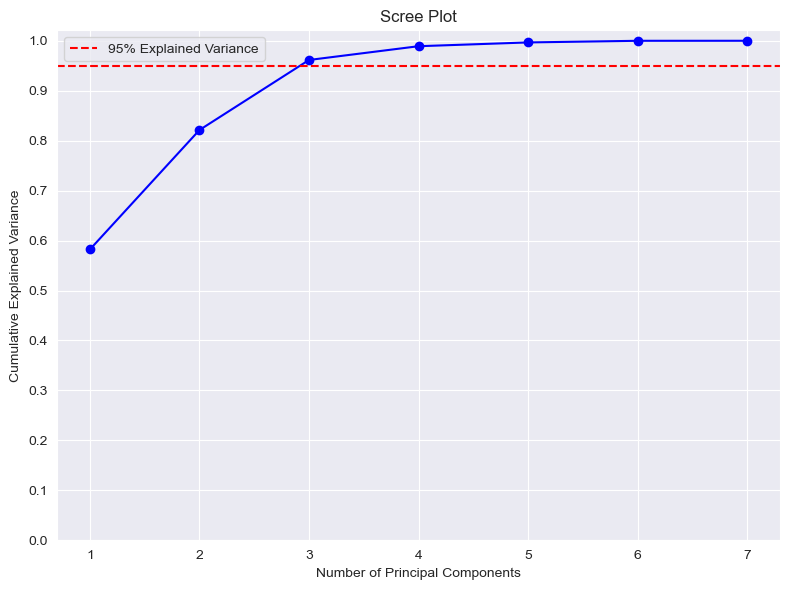

Explained Variance Ratio:
Principal Component 1: 0.5823
Principal Component 2: 0.2390
Principal Component 3: 0.1402
Principal Component 4: 0.0276
Principal Component 5: 0.0076
Principal Component 6: 0.0033
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1: 0.5823
Principal Components 2: 0.8213
Principal Components 3: 0.9615
Principal Components 4: 0.9891
Principal Components 5: 0.9967
Principal Components 6: 0.9999
Principal Components 7: 1.0000


array([[ 1.01960784,  0.98926744,  0.35175141,  0.82120606,  0.8925949 ,
        -0.03288472,  0.71765183],
       [ 0.98926744,  1.01960784,  0.11166391,  0.92816604,  0.76448611,
        -0.0636939 ,  0.81091111],
       [ 0.35175141,  0.11166391,  1.01960784, -0.22245547,  0.69509785,
         0.13349525, -0.19458253],
       [ 0.82120606,  0.92816604, -0.22245547,  1.01960784,  0.46802707,
        -0.08693783,  0.89786016],
       [ 0.8925949 ,  0.76448611,  0.69509785,  0.46802707,  1.01960784,
         0.00114736,  0.37920914],
       [-0.03288472, -0.0636939 ,  0.13349525, -0.08693783,  0.00114736,
         1.01960784, -0.01442654],
       [ 0.71765183,  0.81091111, -0.19458253,  0.89786016,  0.37920914,
        -0.01442654,  1.01960784]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 4.86160122e-01  1.24119043e-01 -2.74144610e-02  1.66107410e-01
  -7.25853912e-01 -4.35038767e-01 -6.14568465e-02]
 [ 4.88721972e-01 -5.71232379e-02 -7.62770952e-04  2.83174421e-01
   6.68659120e-01 -4.79925281e-01  1.63138335e-02]
 [ 1.02001280e-01  7.34169928e-01 -8.79952986e-02 -4.31190469e-01
   1.58836146e-01 -3.28175236e-02 -4.80224897e-01]
 [ 4.40250806e-01 -3.23086852e-01  6.16900977e-02  1.66587957e-01
  -6.54503712e-03  5.55408132e-01 -6.01428190e-01]
 [ 3.94754649e-01  4.38984325e-01 -1.08261584e-01  1.92216236e-01
   2.69136836e-02  5.20389271e-01  5.75555851e-01]
 [-2.46029682e-02  1.90723679e-01  9.75889070e-01  1.01917607e-01
  -2.95319024e-03  7.20957194e-03  1.45532454e-02]
 [ 4.05138985e-01 -3.29936423e-01  1.53684666e-01 -7.94486959e-01
   5.12375195e-03 -9.17280936e-04  2.68605214e-01]]
Eigen Value: [4.15603589e+00 1.70603001e+00 1.00064933e+00 1.96773412e-01
 4.276737

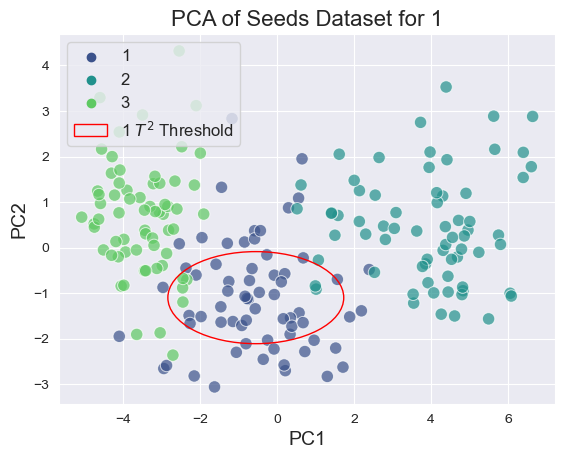

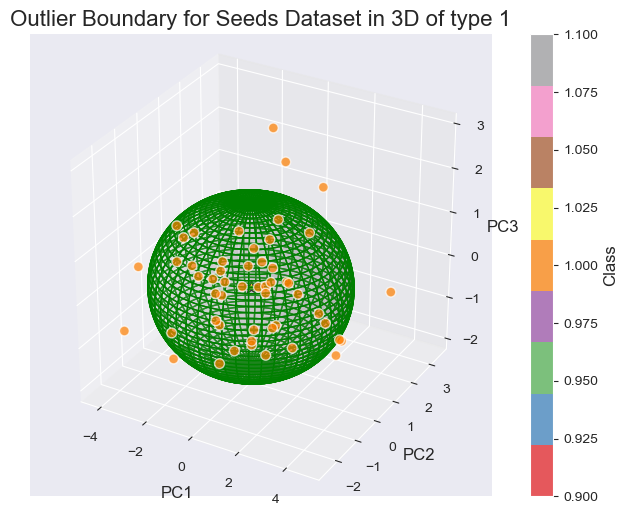

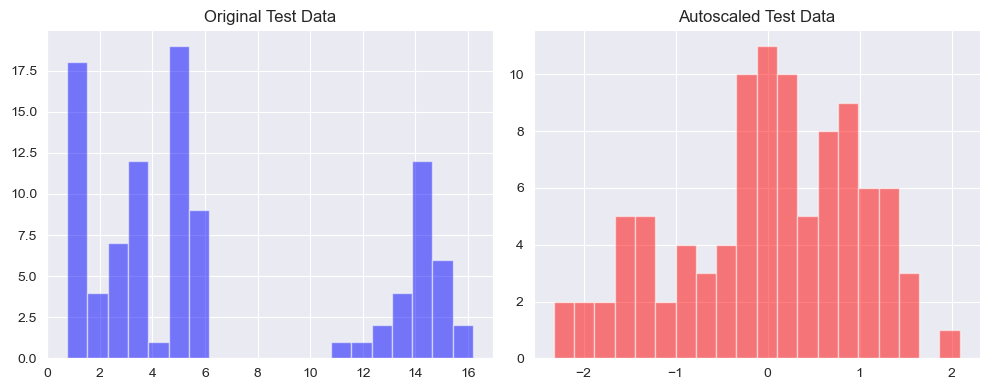

Fault Threhold : 10.105414155861743
T_squared statistic [0.30086346 2.64237014 2.84280146 1.2421455  4.17202916 5.35376338
 8.57669644 1.04922049 2.85543364 4.91957729 0.68285452 2.5199176
 0.26563116 3.10970974] 




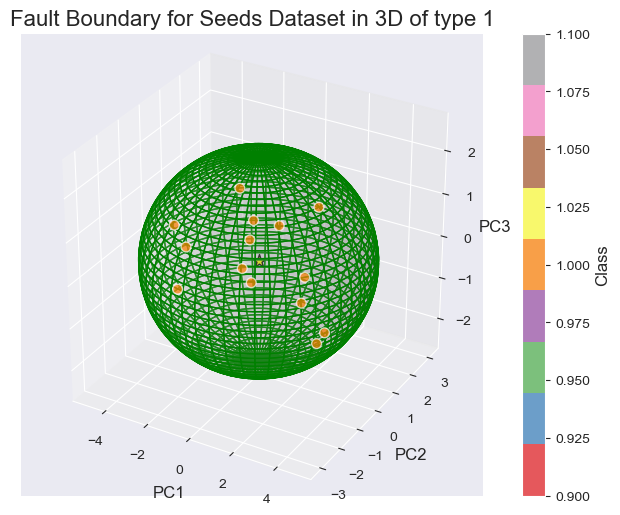

In [21]:
OutlierAndFaultAnalysis(dataset_whole, unique_type[0], alpha_90)

#### For Type 2 - Fault & Outlier Analysis

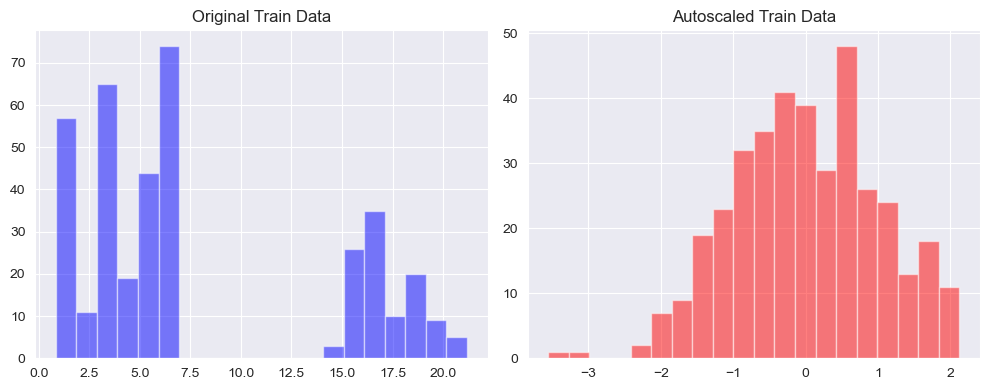

Number of total component : 7
Considerable Principle Component :  3


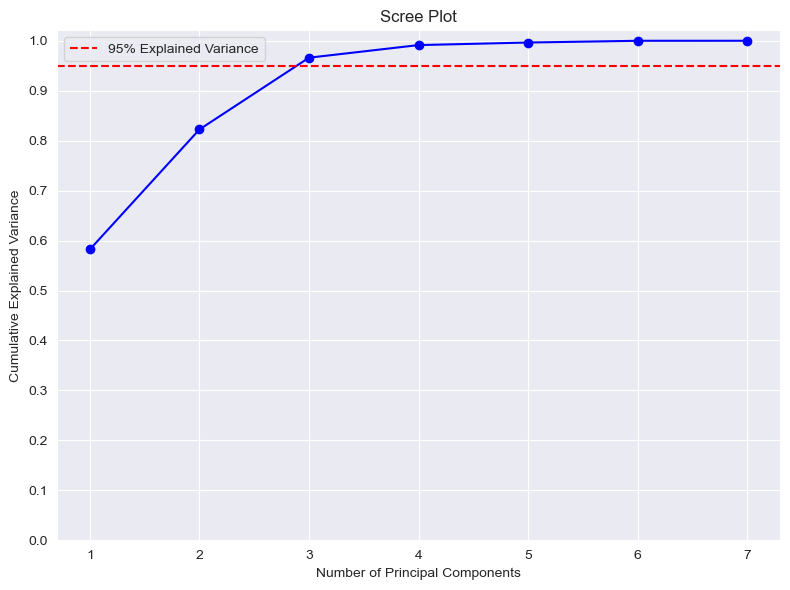

Explained Variance Ratio:
Principal Component 1: 0.5824
Principal Component 2: 0.2401
Principal Component 3: 0.1436
Principal Component 4: 0.0252
Principal Component 5: 0.0051
Principal Component 6: 0.0035
Principal Component 7: 0.0000

Cumulative Explained Variance:
Principal Components 1: 0.5824
Principal Components 2: 0.8225
Principal Components 3: 0.9661
Principal Components 4: 0.9913
Principal Components 5: 0.9965
Principal Components 6: 1.0000
Principal Components 7: 1.0000


array([[ 1.01886792,  0.99361793,  0.34390953,  0.81302107,  0.89805514,
        -0.01682255,  0.69739508],
       [ 0.99361793,  1.01886792,  0.12481932,  0.90405923,  0.78236247,
        -0.0134955 ,  0.79364183],
       [ 0.34390953,  0.12481932,  1.01886792, -0.19980834,  0.70203192,
        -0.05150407, -0.24579297],
       [ 0.81302107,  0.90405923, -0.19980834,  1.01886792,  0.48877586,
         0.00591962,  0.94886106],
       [ 0.89805514,  0.78236247,  0.70203192,  0.48877586,  1.01886792,
         0.03872785,  0.35903265],
       [-0.01682255, -0.0134955 , -0.05150407,  0.00591962,  0.03872785,
         1.01886792, -0.03354219],
       [ 0.69739508,  0.79364183, -0.24579297,  0.94886106,  0.35903265,
        -0.03354219,  1.01886792]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 4.84352604e-01  1.27626025e-01 -1.41587935e-03 -2.54677935e-01
   7.15889754e-01 -3.72725654e-01  1.81187043e-01]
 [ 4.86952210e-01 -3.70862039e-02 -1.30671548e-03 -3.87733362e-01
  -6.79859151e-01 -3.07198201e-01  2.33632385e-01]
 [ 1.01941228e-01  7.33818040e-01 -3.35602406e-02  5.18520720e-01
  -1.58925662e-01 -3.57310380e-01 -1.67931445e-01]
 [ 4.43609074e-01 -3.19341024e-01  5.48540492e-03  9.23124021e-02
  -1.74349735e-03 -3.90155729e-03 -8.32263401e-01]
 [ 3.98355797e-01  4.43207223e-01  6.06284094e-02 -1.52827839e-01
   7.28750738e-04  7.85723774e-01  2.20337062e-02]
 [-4.92294700e-03 -1.64261602e-02  9.96693518e-01  5.46230720e-02
  -5.15838192e-03 -5.49813971e-02  1.65750940e-02]
 [ 4.02973322e-01 -3.81006752e-01 -4.20254107e-02  6.93596889e-01
   2.41867492e-03  1.36506850e-01  4.36993830e-01]]
Eigen Value: [4.15382873e+00 1.71210537e+00 1.02444642e+00 1.79919498e-01
 3.231294

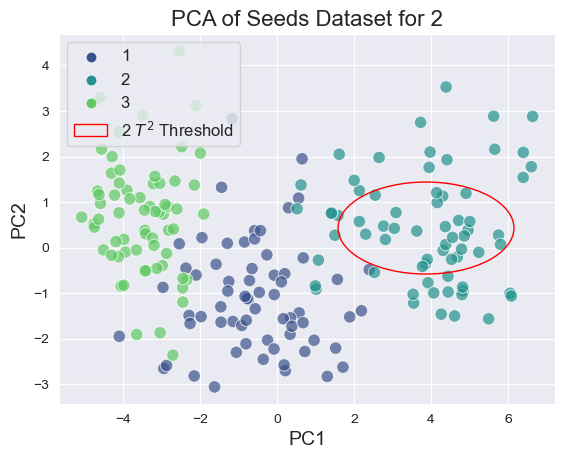

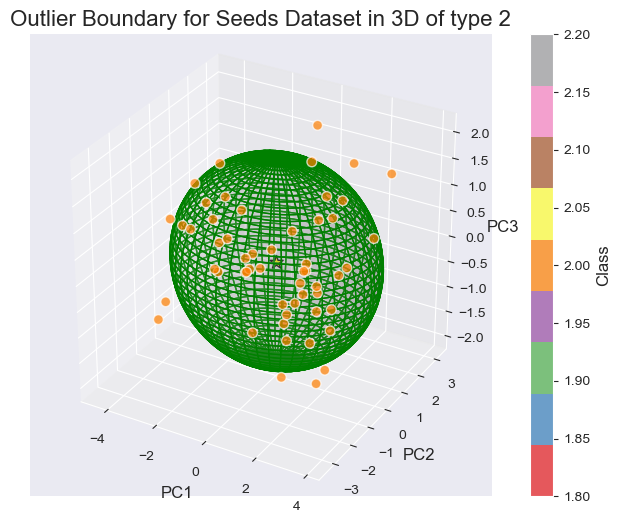

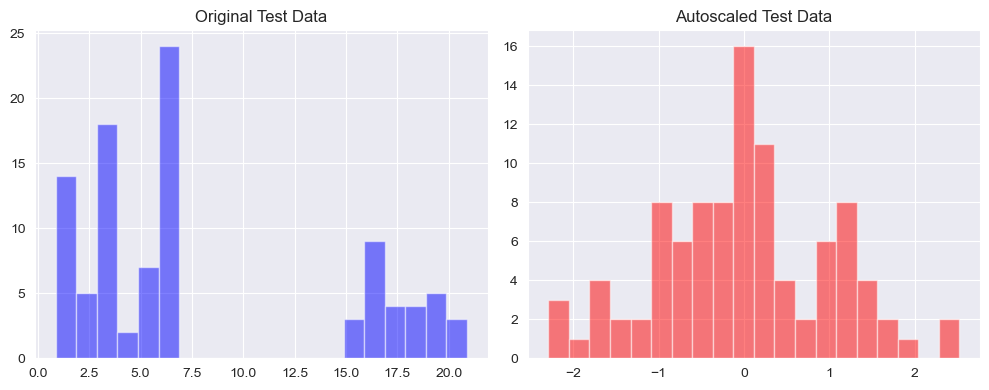

Fault Threhold : 10.105414155861743
T_squared statistic [6.18008886 2.02912177 5.07005525 0.58355396 0.47800707 1.40654738
 7.0315417  5.5454263  1.54597851 0.56926166 5.29676109 1.22412648
 1.93409028 0.35326894] 




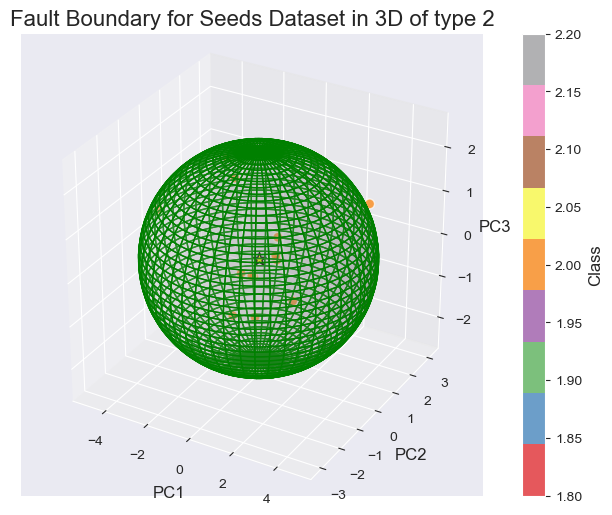

In [22]:
OutlierAndFaultAnalysis(dataset_whole, unique_type[1], alpha_90)

#### For Type 3 - Fault & Outlier Analysis

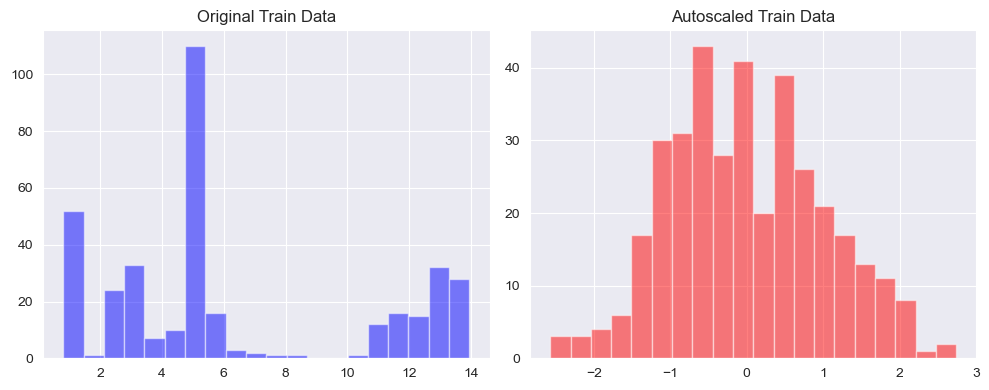

Number of total component : 7
Considerable Principle Component :  3


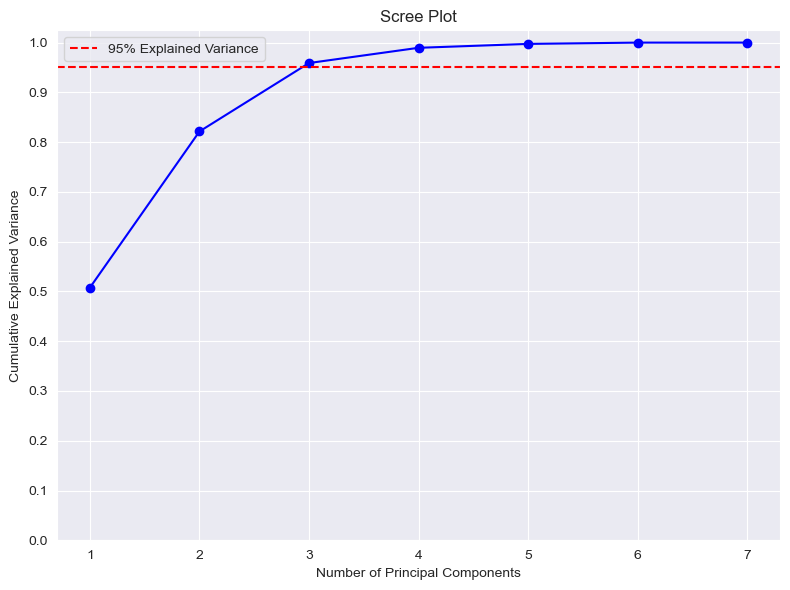

Explained Variance Ratio:
Principal Component 1: 0.5077
Principal Component 2: 0.3138
Principal Component 3: 0.1375
Principal Component 4: 0.0306
Principal Component 5: 0.0078
Principal Component 6: 0.0026
Principal Component 7: 0.0000

Cumulative Explained Variance:
Principal Components 1: 0.5077
Principal Components 2: 0.8215
Principal Components 3: 0.9589
Principal Components 4: 0.9895
Principal Components 5: 0.9973
Principal Components 6: 1.0000
Principal Components 7: 1.0000


array([[ 1.01960784,  0.93297416,  0.5316857 ,  0.6183236 ,  0.89144139,
         0.15443826,  0.39479059],
       [ 0.93297416,  1.01960784,  0.13629352,  0.86052995,  0.6299891 ,
         0.14738729,  0.6481973 ],
       [ 0.5316857 ,  0.13629352,  1.01960784, -0.30510417,  0.85533853,
         0.04961454, -0.40342984],
       [ 0.6183236 ,  0.86052995, -0.30510417,  1.01960784,  0.21144354,
         0.14325732,  0.85538037],
       [ 0.89144139,  0.6299891 ,  0.85533853,  0.21144354,  1.01960784,
         0.19298289,  0.01887418],
       [ 0.15443826,  0.14738729,  0.04961454,  0.14325732,  0.19298289,
         1.01960784,  0.092182  ],
       [ 0.39479059,  0.6481973 , -0.40342984,  0.85538037,  0.01887418,
         0.092182  ,  1.01960784]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 5.08665847e-01  1.68955377e-01  8.98949622e-02  1.56632310e-01
   2.38484086e-01 -7.34898414e-01  2.88353974e-01]
 [ 5.12228576e-01 -9.90736910e-02  8.50687707e-02  3.61328115e-01
   4.41684266e-01  6.14375676e-01  1.32170816e-01]
 [ 1.64903256e-01  6.25655364e-01  5.91062968e-02 -3.75787119e-01
  -3.05991738e-01  2.86295408e-01  5.10937143e-01]
 [ 4.16142221e-01 -3.92748933e-01  2.68769416e-02  2.28870768e-01
  -7.86187843e-01  8.83124179e-03  3.60612485e-02]
 [ 3.97728059e-01  4.39174550e-01  1.02255461e-02 -9.91548593e-02
  -7.36572049e-02  2.02553220e-02 -7.95717409e-01]
 [ 1.26118657e-01  2.25703096e-02 -9.89598117e-01  1.71947907e-03
   2.49593015e-02  3.57625617e-03  6.03449964e-02]
 [ 3.23140813e-01 -4.71760979e-01  3.25158418e-02 -8.00921895e-01
   1.73981985e-01 -8.55026286e-04 -1.47637877e-02]]
Eigen Value: [3.62344893e+00 2.23951679e+00 9.81031721e-01 2.18392128e-01
 5.581238

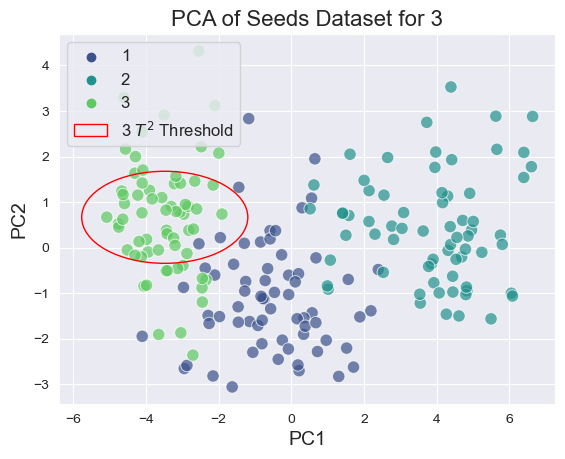

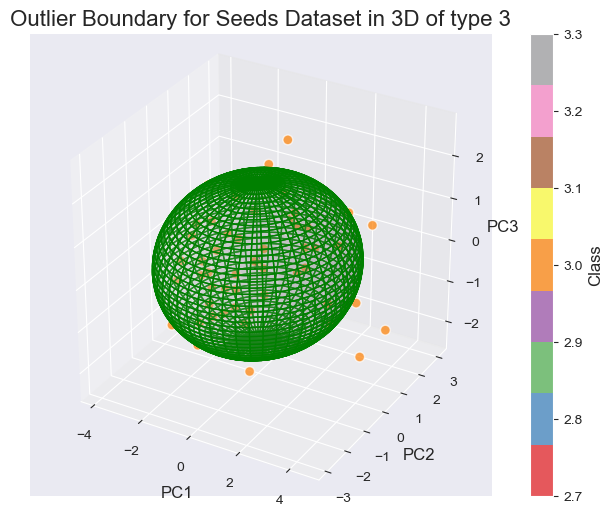

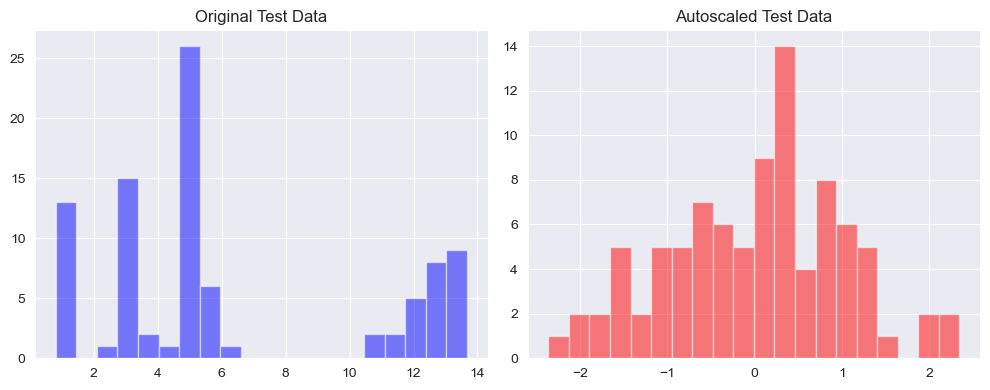

Fault Threhold : 10.574978947286116
T_squared statistic [2.89323945 2.8032127  0.23281619 5.69994453 6.16830164 1.48044732
 5.99367776 3.16279648 1.22292409 0.83350819 9.91110472 1.00492211
 0.90816847] 




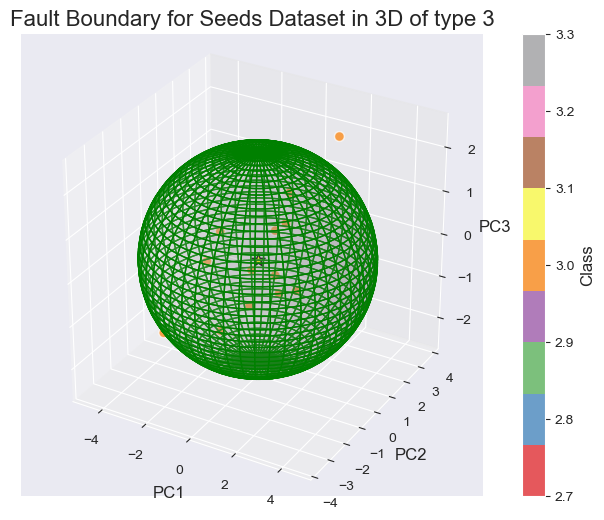

In [23]:
OutlierAndFaultAnalysis(dataset_whole, unique_type[2], alpha_90)

### Conclusion on Outlier Detection : 

###### 1. We have performed the outlier detection on type wise Train dataset.

###### 2. In the context of Principal Component Analysis (PCA), 𝑇2 statistic is an effective tool for detecting outliers. This is essentially a multivariate generalization of Student's t-statistic and it measures the distance of a data point in the transformed space from the origin.

###### 3. By projecting our multi-dimensional dataset into a lower-dimensional space via PCA, we created a scatter plot of the transformed data. As seen in our visualizations, the elliptical boundary (illustrated in green) encapsulates the majority of our data points. This boundary represents the calculated 𝑇2 statistic threshold, beyond which points are considered unusual with respect to the multivariate distribution of our dataset.

    - PCA analysis on the Type 1 data reveals that 3 PC is needed to maintain 95% information (explained variance) in the given data.
    - Considering the fact we have used 3D plot to show the outlier for different types of data.
    - All the point outside the green elliptical boundary, considered as outlier.
    - These points deviate significantly from the overall distribution thus placed outside the boundary.

### Conclusion on Fault Identification : 
###### 1. We have performed the outlier detection on type wise Test dataset.

##### 2. In the world of multivariate process monitoring, PCA combined with Hotelling’s $T^2$ statistic is a powerful methodology for detecting faults or anomalies in the system. In essence, PCA reduces the dimensionality of the data, thereby eliminating the potential issues caused by multicollinearity and helping to clarify the structure of the data. Hotelling’s $T^2$ statistic, on the other hand, is a multivariate measure of the deviation of a given observation from the mean of the observations, serving as a generalized form of the t-statistic for multivariate data.

    - PCA analysis on the Type 1 data reveals that 3 PC is needed to maintain 95% information (explained variance) in the given data.
    - Considering the fact we have used 3D plot to show the outlier for different types of data.
    - All the point outside the green elliptical boundary, considered as fault.
    - These points deviate significantly from the overall distribution thus placed outside the boundary.

###### 3. In essence, the points lying outside this boundary represent conditions or states where the system behaves differently than usual. Identifying these states is crucial in process monitoring and control to prevent suboptimal operation or even system failure.